<a href="https://colab.research.google.com/github/jayshah18/Sentiment_Analysis/blob/main/sentiment_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as  np

In [6]:
import os
import librosa

def review_dataset(dataset_path):
    total_files = 0
    summary = {}

    for actor_folder in sorted(os.listdir(dataset_path)):
        actor_path = os.path.join(dataset_path, actor_folder)
        if os.path.isdir(actor_path):
            file_list = [f for f in os.listdir(actor_path) if f.endswith(".wav") or f.endswith(".mp3")]
            total_files += len(file_list)

            durations = []
            for file in file_list:
                file_path = os.path.join(actor_path, file)
                signal, sr = librosa.load(file_path, sr=None)
                durations.append(librosa.get_duration(y=signal, sr=sr))

            summary[actor_folder] = {
                "file_count": len(file_list),
                "avg_duration_sec": round(sum(durations)/len(durations), 2) if durations else 0
            }

    print(f"\n✅ Total Actors: {len(summary)}")
    print(f"✅ Total Audio Files: {total_files}\n")

    for actor, stats in summary.items():
        print(f"{actor}: {stats['file_count']} files | Avg Duration: {stats['avg_duration_sec']} sec")

# Run this
review_dataset("/content/drive/MyDrive/DATASET")



✅ Total Actors: 24
✅ Total Audio Files: 1440

Actor_01: 60 files | Avg Duration: 3.75 sec
Actor_02: 60 files | Avg Duration: 3.79 sec
Actor_03: 60 files | Avg Duration: 3.76 sec
Actor_04: 60 files | Avg Duration: 3.63 sec
Actor_05: 60 files | Avg Duration: 3.74 sec
Actor_06: 60 files | Avg Duration: 3.79 sec
Actor_07: 60 files | Avg Duration: 3.75 sec
Actor_08: 60 files | Avg Duration: 3.73 sec
Actor_09: 60 files | Avg Duration: 3.49 sec
Actor_10: 60 files | Avg Duration: 3.75 sec
Actor_11: 60 files | Avg Duration: 3.44 sec
Actor_12: 60 files | Avg Duration: 3.75 sec
Actor_13: 60 files | Avg Duration: 3.33 sec
Actor_14: 60 files | Avg Duration: 3.68 sec
Actor_15: 60 files | Avg Duration: 3.5 sec
Actor_16: 60 files | Avg Duration: 3.73 sec
Actor_17: 60 files | Avg Duration: 3.67 sec
Actor_18: 60 files | Avg Duration: 3.75 sec
Actor_19: 60 files | Avg Duration: 3.87 sec
Actor_20: 60 files | Avg Duration: 3.73 sec
Actor_21: 60 files | Avg Duration: 3.92 sec
Actor_22: 60 files | Avg Durat

In [7]:
import os
import pandas as pd

def create_dataset_dataframe(dataset_path):
    """
    Parses the RAVDESS dataset filenames to create a structured DataFrame.

    The RAVDESS filename consists of a 7-part numerical identifier (e.g., 03-01-01-01-01-01-01.wav).
    The 3rd part identifies the emotion.

    Args:
        dataset_path (str): The root path to the RAVDESS dataset (e.g., '/content/drive/MyDrive/DATASET').

    Returns:
        pandas.DataFrame: A DataFrame with columns for filepath, actor, and emotion.
    """

    # Emotion labels mapping from the RAVDESS documentation
    emotion_map = {
        "01": "neutral",
        "02": "calm",
        "03": "happy",
        "04": "sad",
        "05": "angry",
        "06": "fearful",
        "07": "disgust",
        "08": "surprised"
    }

    data = []

    print(f"Parsing dataset from: {dataset_path}")

    for actor_folder in sorted(os.listdir(dataset_path)):
        actor_path = os.path.join(dataset_path, actor_folder)
        if os.path.isdir(actor_path):
            for file_name in os.listdir(actor_path):
                if file_name.endswith(".wav"):
                    parts = file_name.split(".")[0].split("-")

                    # Ensure the filename has the correct number of parts
                    if len(parts) == 7:
                        emotion_code = parts[2]
                        actor_id = parts[6]
                        file_path = os.path.join(actor_path, file_name)

                        # Get the emotion label from the map
                        emotion_label = emotion_map.get(emotion_code)

                        if emotion_label:
                            data.append({
                                "filepath": file_path,
                                "actor": actor_id,
                                "emotion": emotion_label
                            })
                        else:
                            print(f"Warning: Unknown emotion code '{emotion_code}' in file {file_name}")

    if not data:
        print("\nError: No data was loaded. Please check the following:")
        print(f"1. Does the path '{dataset_path}' exist?")
        print("2. Is it the correct root folder containing the 'Actor_01', 'Actor_02', etc. subfolders?")
        return None

    # Create a DataFrame
    df = pd.DataFrame(data)
    print(f"\n✅ Successfully created DataFrame with {len(df)} entries.")
    return df

# --- HOW TO RUN THIS SCRIPT ---
# 1. Make sure pandas is installed: pip install pandas
# 2. Update the dataset_path to your actual path
# 3. Run the script

if __name__ == '__main__':
    dataset_path = "/content/drive/MyDrive/DATASET"
    ravdess_df = create_dataset_dataframe(dataset_path)

    if ravdess_df is not None:
        # Display the first few rows of the DataFrame
        print("\n--- DataFrame Head ---")
        print(ravdess_df.head())

        # Display the distribution of emotions
        print("\n--- Emotion Distribution ---")
        print(ravdess_df['emotion'].value_counts())


Parsing dataset from: /content/drive/MyDrive/DATASET

✅ Successfully created DataFrame with 1440 entries.

--- DataFrame Head ---
                                            filepath actor  emotion
0  /content/drive/MyDrive/DATASET/Actor_01/03-01-...    01  neutral
1  /content/drive/MyDrive/DATASET/Actor_01/03-01-...    01     calm
2  /content/drive/MyDrive/DATASET/Actor_01/03-01-...    01  neutral
3  /content/drive/MyDrive/DATASET/Actor_01/03-01-...    01     calm
4  /content/drive/MyDrive/DATASET/Actor_01/03-01-...    01     calm

--- Emotion Distribution ---
emotion
calm         193
happy        192
sad          192
fearful      192
angry        192
disgust      192
surprised    191
neutral       96
Name: count, dtype: int64


In [8]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm

def create_dataset_dataframe(dataset_path):
    """
    Parses the RAVDESS dataset filenames to create a structured DataFrame.
    This is the same function from the previous script.
    """
    emotion_map = {
        "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
        "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
    }
    data = []
    print(f"Parsing dataset from: {dataset_path}")
    for actor_folder in sorted(os.listdir(dataset_path)):
        actor_path = os.path.join(dataset_path, actor_folder)
        if os.path.isdir(actor_path):
            for file_name in os.listdir(actor_path):
                if file_name.endswith(".wav"):
                    parts = file_name.split(".")[0].split("-")
                    if len(parts) == 7:
                        emotion_code = parts[2]
                        actor_id = parts[6]
                        file_path = os.path.join(actor_path, file_name)
                        emotion_label = emotion_map.get(emotion_code)
                        if emotion_label:
                            data.append({
                                "filepath": file_path,
                                "actor": actor_id,
                                "emotion": emotion_label
                            })
    if not data:
        print("\nError: No data was loaded.")
        return None
    df = pd.DataFrame(data)
    print(f"\n✅ Successfully created DataFrame with {len(df)} entries.")
    return df

def extract_features(file_path):
    """
    Extracts Mel Spectrogram and aggregated features (MFCC, Chroma, ZCR) from an audio file.
    """
    try:
        # Load audio file at a consistent sample rate
        signal, sample_rate = librosa.load(file_path, sr=22050)

        # --- Features for Deep Learning Models (CNN, LSTM) ---
        # Mel Spectrogram (for CNNs)
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=128)

        # --- Features for Traditional ML Models (SVM, Random Forest) ---
        # MFCCs, Chroma, Zero-Crossing Rate
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
        zcr = librosa.feature.zero_crossing_rate(y=signal)

        # Aggregate features by taking the mean across time
        mfccs_mean = np.mean(mfccs, axis=1)
        chroma_mean = np.mean(chroma, axis=1)
        zcr_mean = np.mean(zcr, axis=1)

        # Combine aggregated features into a single feature vector
        aggregated_features = np.hstack([mfccs_mean, chroma_mean, zcr_mean])

        return mel_spectrogram, aggregated_features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None


# --- HOW TO RUN THIS SCRIPT ---
# 1. Make sure pandas, librosa, numpy, and tqdm are installed.
#    pip install pandas librosa numpy tqdm
# 2. Update the dataset_path.
# 3. Run the script. It will save a 'features_dataframe.pkl' file.

if __name__ == '__main__':
    # Initialize tqdm to work with pandas .apply()
    tqdm.pandas()

    dataset_path = "/content/drive/MyDrive/DATASET"
    ravdess_df = create_dataset_dataframe(dataset_path)

    if ravdess_df is not None:
        print("\nExtracting features from audio files... (This may take a few minutes)")

        # Apply the feature extraction function to each file
        # The result of the lambda function is a tuple, which pandas expands into two new columns
        ravdess_df[['mel_spectrogram', 'aggregated_features']] = ravdess_df['filepath'].progress_apply(
            lambda filepath: pd.Series(extract_features(filepath))
        )

        # Drop rows where feature extraction might have failed
        ravdess_df.dropna(inplace=True)

        # Save the feature-rich dataframe to a pickle file for quick loading later
        output_path = "features_dataframe.pkl"
        ravdess_df.to_pickle(output_path)

        print(f"\n✅ Feature extraction complete.")
        print(f"✅ DataFrame saved to '{output_path}'")
        print("\n--- DataFrame Head with New Features ---")
        print(ravdess_df.head())


Parsing dataset from: /content/drive/MyDrive/DATASET

✅ Successfully created DataFrame with 1440 entries.

Extracting features from audio files... (This may take a few minutes)


100%|██████████| 1440/1440 [01:39<00:00, 14.42it/s]



✅ Feature extraction complete.
✅ DataFrame saved to 'features_dataframe.pkl'

--- DataFrame Head with New Features ---
                                            filepath actor  emotion  \
0  /content/drive/MyDrive/DATASET/Actor_01/03-01-...    01  neutral   
1  /content/drive/MyDrive/DATASET/Actor_01/03-01-...    01     calm   
2  /content/drive/MyDrive/DATASET/Actor_01/03-01-...    01  neutral   
3  /content/drive/MyDrive/DATASET/Actor_01/03-01-...    01     calm   
4  /content/drive/MyDrive/DATASET/Actor_01/03-01-...    01     calm   

                                     mel_spectrogram  \
0  [[1.9769283e-07, 3.2483592e-07, 1.3091303e-06,...   
1  [[4.4146126e-10, 1.5210988e-08, 1.9769656e-08,...   
2  [[1.3324016e-07, 1.4781753e-07, 1.0845676e-07,...   
3  [[2.1944395e-09, 3.8604355e-08, 7.6826e-08, 1....   
4  [[4.6863455e-08, 1.553473e-08, 6.2439507e-09, ...   

                                 aggregated_features  
0  [-691.587890625, 58.024662017822266, 0.1594650...  
1  [-6

✅ Successfully loaded features DataFrame.

--- Data Split Summary ---
Training set size: 960 samples (17 actors)
Validation set size: 240 samples (4 actors)
Test set size: 240 samples (4 actors)

--- Training Support Vector Machine (SVM) ---

SVM Classification Report:
              precision    recall  f1-score   support

       angry       0.34      0.69      0.46        32
        calm       0.24      0.38      0.29        32
     disgust       0.38      0.16      0.22        32
     fearful       0.42      0.34      0.38        32
       happy       0.42      0.16      0.23        32
     neutral       0.18      0.12      0.15        16
         sad       0.22      0.34      0.27        32
   surprised       0.38      0.16      0.22        32

    accuracy                           0.30       240
   macro avg       0.32      0.29      0.28       240
weighted avg       0.33      0.30      0.29       240


--- Training Random Forest ---

Random Forest Classification Report:
         

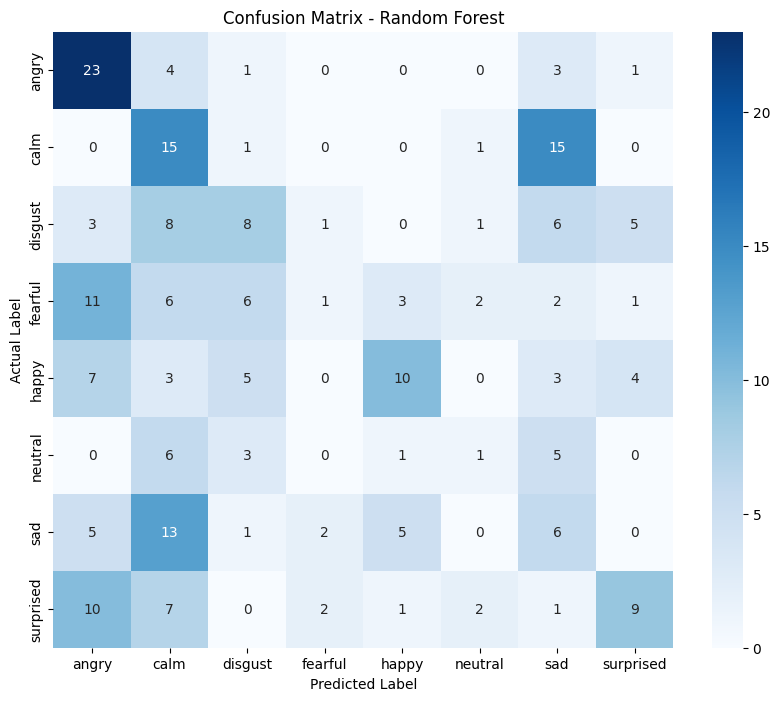

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_and_evaluate_models(features_path="features_dataframe.pkl"):
    """
    Loads features, performs an actor-independent split, and trains/evaluates
    SVM and Random Forest models.
    """
    # --- 1. Load Data ---
    try:
        df = pd.read_pickle(features_path)
    except FileNotFoundError:
        print(f"Error: The file '{features_path}' was not found.")
        print("Please run the 'feature_extraction.py' script first.")
        return

    print("✅ Successfully loaded features DataFrame.")

    # --- 2. Prepare Data for ML ---
    # Convert list of aggregated features into a proper 2D numpy array for sklearn
    X = np.array(df['aggregated_features'].tolist())

    # Encode the string labels ('happy', 'sad', etc.) into numbers
    y = df['emotion']
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # --- 3. Actor-Independent Split ---
    # This is the most important step for a fair evaluation.
    # We split based on actor IDs, not random rows.
    actor_ids = df['actor'].unique()
    train_actors, test_actors = train_test_split(actor_ids, test_size=0.15, random_state=42)
    train_actors, val_actors = train_test_split(train_actors, test_size=(0.15/0.85), random_state=42) # 0.15/0.85 is ~17.6% of the 85%

    # Create the data splits based on actor IDs
    train_indices = df['actor'].isin(train_actors)
    val_indices = df['actor'].isin(val_actors)
    test_indices = df['actor'].isin(test_actors)

    X_train, y_train = X[train_indices], y_encoded[train_indices]
    X_val, y_val = X[val_indices], y_encoded[val_indices]
    X_test, y_test = X[test_indices], y_encoded[test_indices]

    print("\n--- Data Split Summary ---")
    print(f"Training set size: {len(X_train)} samples ({len(train_actors)} actors)")
    print(f"Validation set size: {len(X_val)} samples ({len(val_actors)} actors)")
    print(f"Test set size: {len(X_test)} samples ({len(test_actors)} actors)")

    # --- 4. Feature Scaling (for SVM) ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- 5. Train and Evaluate SVM ---
    print("\n--- Training Support Vector Machine (SVM) ---")
    svm_model = SVC(kernel='rbf', C=10, gamma='auto', probability=True, random_state=42)
    svm_model.fit(X_train_scaled, y_train)

    svm_predictions = svm_model.predict(X_test_scaled)
    print("\nSVM Classification Report:")
    print(classification_report(y_test, svm_predictions, target_names=label_encoder.classes_))

    # --- 6. Train and Evaluate Random Forest ---
    print("\n--- Training Random Forest ---")
    rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
    rf_model.fit(X_train, y_train) # Note: Uses unscaled data

    rf_predictions = rf_model.predict(X_test)
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test, rf_predictions, target_names=label_encoder.classes_))

    # --- 7. Visualization (Confusion Matrix for the better model) ---
    # Let's assume Random Forest performs better for visualization
    cm = confusion_matrix(y_test, rf_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix - Random Forest')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


# --- HOW TO RUN THIS SCRIPT ---
# 1. Make sure scikit-learn, seaborn, and matplotlib are installed.
#    pip install scikit-learn seaborn matplotlib
# 2. Make sure the 'features_dataframe.pkl' file is in the same directory.
# 3. Run the script.

if __name__ == '__main__':
    train_and_evaluate_models()

✅ Successfully loaded features DataFrame.

--- Data Split Summary ---
Training set shape: (960, 128, 174, 1), Labels shape: (960,)
Validation set shape: (240, 128, 174, 1), Labels shape: (240,)
Test set shape: (240, 128, 174, 1), Labels shape: (240,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 172, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,587,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,681,352 (17.86 MB)

 Trainable params: 4,681,352 (17.86 MB)

 Non-trainable params: 0 (0.00 B)


--- Training CNN Model ---
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.1683 - loss: 4.1448 - val_accuracy: 0.2750 - val_loss: 1.9063
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2356 - loss: 1.9052 - val_accuracy: 0.3250 - val_loss: 1.8964
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2883 - loss: 1.8323 - val_accuracy: 0.3542 - val_loss: 1.8351
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.3267 - loss: 1.7552 - val_accuracy: 0.3500 - val_loss: 1.8651
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.3433 - loss: 1.7113 - val_accuracy: 0.3583 - val_loss: 1.9669
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3518 - loss: 1.6540 - val_accuracy: 0.3583 - val_loss: 2.0306
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3712 - loss: 1.7250 - val_accuracy: 0.4000 - val_loss: 2.0503
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3799 - loss: 1.6100 - val_

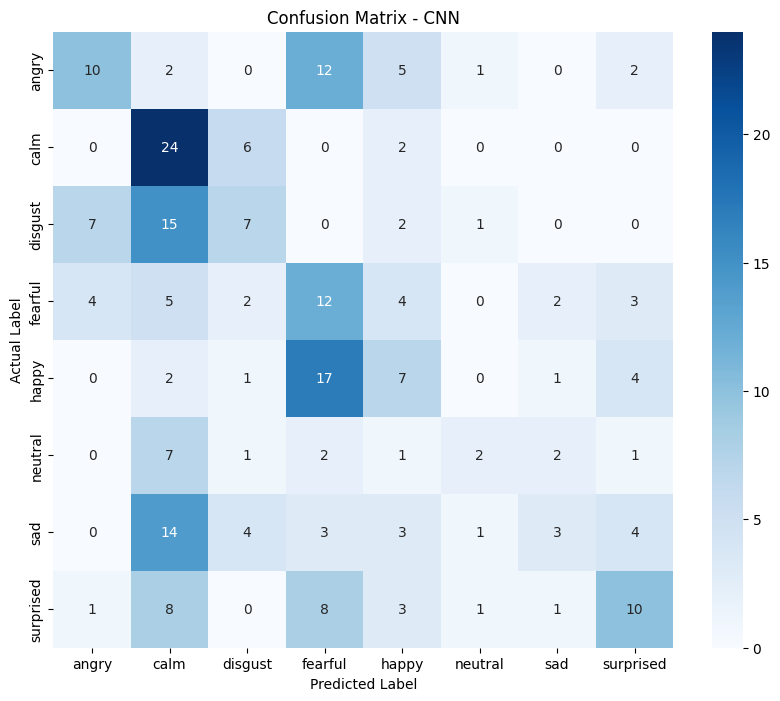

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical

def train_cnn_model(features_path="features_dataframe.pkl"):
    """
    Loads features, prepares spectrogram data, and trains/evaluates a CNN model.
    """
    # --- 1. Load Data ---
    try:
        df = pd.read_pickle(features_path)
    except FileNotFoundError:
        print(f"Error: The file '{features_path}' was not found.")
        print("Please run the 'feature_extraction.py' script first.")
        return

    print("✅ Successfully loaded features DataFrame.")

    # --- 2. Prepare Data for CNN ---
    # The CNN expects image-like data, so we use the mel_spectrograms
    X_spectrograms = df['mel_spectrogram'].tolist()

    # Pad or truncate spectrograms to a fixed size for consistent input shape
    max_pad_len = 174 # Based on analysis of RAVDESS durations

    def pad_spectrogram(spec, max_len):
        if spec.shape[1] > max_len:
            return spec[:, :max_len]
        else:
            padding = max_len - spec.shape[1]
            return np.pad(spec, ((0, 0), (0, padding)), mode='constant')

    X_padded = np.array([pad_spectrogram(s, max_pad_len) for s in X_spectrograms])

    # Add a 'channel' dimension for the CNN (like a grayscale image)
    X_reshaped = X_padded[..., np.newaxis]

    # Encode the string labels ('happy', 'sad', etc.) into numbers
    y = df['emotion']
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # --- 3. Actor-Independent Split ---
    actor_ids = df['actor'].unique()
    train_actors, test_actors = train_test_split(actor_ids, test_size=0.15, random_state=42)
    train_actors, val_actors = train_test_split(train_actors, test_size=(0.15/0.85), random_state=42)

    train_indices = df['actor'].isin(train_actors)
    val_indices = df['actor'].isin(val_actors)
    test_indices = df['actor'].isin(test_actors)

    X_train, y_train = X_reshaped[train_indices], y_encoded[train_indices]
    X_val, y_val = X_reshaped[val_indices], y_encoded[val_indices]
    X_test, y_test = X_reshaped[test_indices], y_encoded[test_indices]

    print("\n--- Data Split Summary ---")
    print(f"Training set shape: {X_train.shape}, Labels shape: {y_train.shape}")
    print(f"Validation set shape: {X_val.shape}, Labels shape: {y_val.shape}")
    print(f"Test set shape: {X_test.shape}, Labels shape: {y_test.shape}")

    # --- 4. Define CNN Model Architecture ---
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax') # Output layer
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # --- 5. Train the Model ---
    print("\n--- Training CNN Model ---")
    history = model.fit(X_train, y_train,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        batch_size=32,
                        verbose=1)


    # --- 6. Evaluate the Model ---
    print("\n--- Evaluating CNN Model on Test Set ---")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Get predictions to generate a classification report
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nCNN Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # --- 7. Visualization ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix - CNN')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


# --- HOW TO RUN THIS SCRIPT ---
# 1. Make sure tensorflow, scikit-learn, seaborn, and matplotlib are installed.
#    pip install tensorflow scikit-learn seaborn matplotlib
# 2. Make sure the 'features_dataframe.pkl' file is in the same directory.
# 3. Run the script.

if __name__ == '__main__':
    train_cnn_model()
